In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt; plt.style.use('ggplot')

In [2]:
pd.set_option('display.max_columns', None)

In [47]:
data = pd.read_csv('/Users/willfitzhugh/Desktop/Coding/Supply-Chain-Analysis/Data/Interim/Ready_For_Fraud_Featuers.csv')
copy = data.copy()

In [168]:
data = copy.copy()

In [93]:
#feature engineering to deal with catagorical variables with high cardinality:
#flag cities and states with high fraud rate, and those with no recorded fraud
#same with product names
#cols to engineer: ProductCategory, Customer State, Customer City, ProductDepartment, Order City, Order Country, Order region,
#Order state, Product Name

#cols to remove: Customer Id, Latitude, Longitude, Order date, Ship date, Order Id, Order status, Customer Name,
#order year, real ship days, delivery status, late_delivery_risk, order Status, order year and probably one or more 
#of [OrderProfit, OrderSales, Order Item Discount, Order Item Discount Rate,Order Item Profit Ratio, product price]

#cols to one hot encode: PaymentType, Customer Country, Customer Segment, Market, shipping mode, Order DOW

In [169]:
dums = pd.get_dummies(data[['PaymentType', 'Customer Country', 'Customer Segment', 'Market', 'Shipping Mode',
                            'OrderDOW']])

data = pd.concat([data,dums], axis=1).drop(columns=['PaymentType', 'Customer Country', 'Customer Segment', 'Market',
                                             'Shipping Mode','OrderDOW'])

In [170]:
#have different approach with columns with high cardinality. order city has much higher cardinality than order region
#and should be binned differently
'''
want to keep bins from over fitting to highly cardinal data. I want to avoid marking a city as extremely high risk 
just because it has one fraud order, and zero non-fraud orders. I still want to mark it has higher risk, but marking
it as garaunteed fraud might cause data leakage and over fitting.
'''
bin_cols = ['ProductCategory', 'Customer State', 'Customer City', 'ProductDepartment', 'Order City', 'Order Country',
            'Order Region', 'Order State', 'Product Name']

for i in bin_cols: 

    grouped = data.groupby(i).mean()[['IsFraud']].sort_values('IsFraud', ascending=False).reset_index()
    binned = stats.binned_statistic(x = grouped['IsFraud'], values = grouped['IsFraud'], bins = [0, .001, .015, .02, .03, .045, .2, 1])

    grouped['bin'] = binned[2]
    
    bin_map = grouped[[i,'bin']].set_index(i).to_dict()['bin']
    
    data[i] = data[i].map( bin_map )
    
    
'''
This mapping strategy/ target encoding in general presents a problem. I may not have data on an order city, so 
my model will not be able to handle the order. I could create another model, one that doesn't depend on order city
and use that model if the input order has an order city that didn't appear in the train dataset.
'''

"\nThis mapping strategy/ target encoding in general presents a problem. I may not have data on an order city, so \nmy model will not be able to handle the order. I could create another model, one that doesn't depend on order city\nand use that model if the input order has an order city that didn't appear in the train dataset.\n"

In [171]:
data = data.drop(columns = ['Customer Id','Latitude','Longitude','OrderDate','ShipDate','Order Id','Order Status', 
                  'CustomerName', 'OrderYear', 'RealShippingDays', 'Delivery Status', 'Late_delivery_risk',
                  'Order Status','OrderHour','OrderMonth','Order Item Discount','OrderProfit','Order Item Quantity'])


In [172]:
data.IsFraud = data.IsFraud.map({True:1,False:0})

In [173]:
X = data.drop(columns=['IsFraud'])
y = data.IsFraud

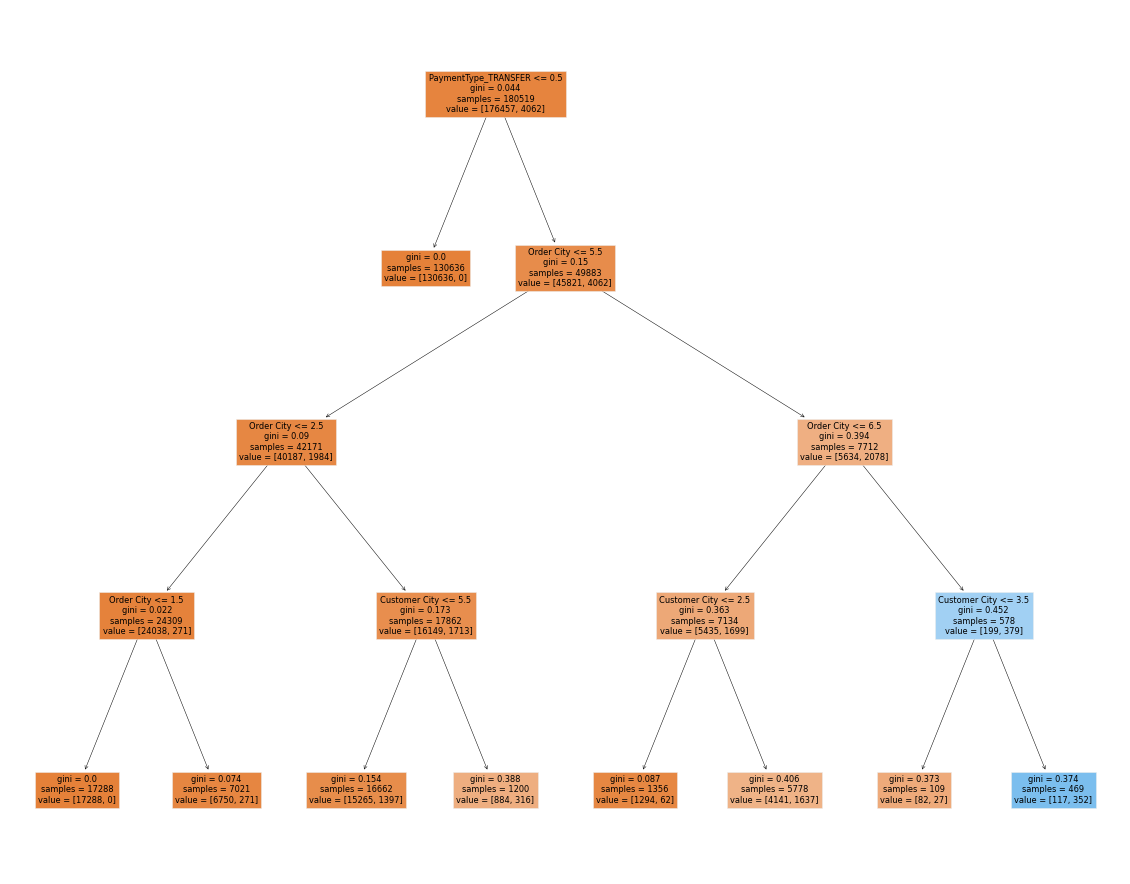

In [174]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(max_depth = 4).fit( X, y )

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree, feature_names = X.columns, filled = True);

In [175]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [148]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RFC = RandomForestClassifier()

#grid search
grid_values = {
    'criterion':['gini', 'log_loss'],
    'n_estimators':[10, 50, 100]
}
RFC_gridsearch = GridSearchCV(RFC, param_grid = grid_values, scoring = 'precision', cv=5)
RFC_gridsearch.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'log_loss'],
                         'n_estimators': [10, 50, 100]},
             scoring='precision')

In [149]:
#grid search CV results
pd.DataFrame(RFC_gridsearch.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,4.635369,0.126661,0.201974,0.009560,log_loss,100,"{'criterion': 'log_loss', 'n_estimators': 100}",0.868687,0.810811,0.913462,0.838983,0.849057,0.856200,0.034183,1
2,4.709695,0.087387,0.224495,0.027762,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.857143,0.823009,0.860870,0.793651,0.878261,0.842587,0.030321,2
4,2.705307,0.140137,0.132697,0.007279,log_loss,50,"{'criterion': 'log_loss', 'n_estimators': 50}",0.846939,0.827273,0.871212,0.801587,0.841667,0.837736,0.022965,3
1,2.330409,0.053690,0.108355,0.004545,gini,50,"{'criterion': 'gini', 'n_estimators': 50}",0.801887,0.806723,0.894309,0.820896,0.842857,0.833334,0.033647,4
3,0.601135,0.026909,0.038570,0.004230,log_loss,10,"{'criterion': 'log_loss', 'n_estimators': 10}",0.740157,0.692308,0.683168,0.669231,0.714286,0.699830,0.024923,5


In [176]:
RFC = RandomForestClassifier(criterion='log_loss',n_estimators=200)
RFC.fit(X_train, y_train)
print('Train Score: ', RFC.score(X_train, y_train))
print('Test Score: ', RFC.score(X_test, y_test))

Train Score:  0.9999762588732461
Test Score:  0.9820703153851835


In [177]:
from sklearn.metrics import confusion_matrix
confusion_matrix(RFC.predict(X_test), y_test, labels=[1,0])

array([[  311,    29],
       [  942, 52874]])

In [ ]:
'''
this random forest model correctly predicts 311 fraud cases out of 1253 in the total test set, and only incorrectly
classifies 29 non-fraud cases as fraud. If the company were to automatically disregard these 311 orders marked as 
fraud by, they would save $X, and would only lose $X on real orders presumed to be fraud. The other 942 cases which
are not marked as fraud can be assessed by human judgement. 
'''

In [178]:
RFC.predict(X_test).mean()

0.0062781593913878424

In [182]:
y_test.mean()

0.023136863874732256

---
.

.

.

.

.

.

.

.

.

.

.


---

In [ ]:
'''
The purpose of this model is to save this company money by detecting likely fraud orders. By the same token, the
the model should not incorrectly mark orders as fraud, as canceling a non-fraud order loses the company money just
the same as accepting a fraud order. As such, the model will aim to reduce false positives.

'''

In [6]:
np.round(stats.zscore(data.groupby('Order Region').mean()[['IsFraud']].sort_values('IsFraud', ascending=False)))

,IsFraud
Order Region,
Canada,2.0
West of USA,2.0
Southern Africa,1.0
Western Europe,1.0
West Asia,1.0
South America,1.0
Southern Europe,0.0
North Africa,0.0
Caribbean,0.0


<AxesSubplot:ylabel='Frequency'>

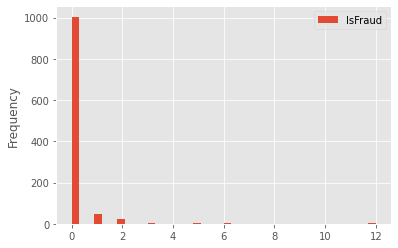

In [12]:
#zscore doesn't work as well, bc the states with exceptionally high fraud skew the mean
np.round(stats.zscore(data.groupby('Order State').mean()[['IsFraud']].sort_values('IsFraud', ascending=False))
        ).reset_index().plot.hist(column = 'IsFraud', bins=40)

<AxesSubplot:ylabel='Frequency'>

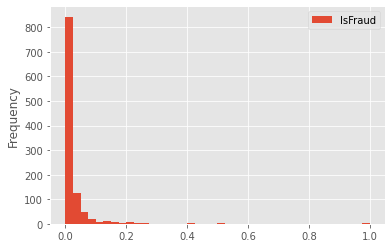

In [14]:
data.groupby('Order State').mean()[['IsFraud']].sort_values('IsFraud', ascending=False
                                ).reset_index().plot.hist(column = 'IsFraud', bins=40)

In [ ]:
# change percentage into Z score, bin by Z score
# just use avg fraud rate for that catagorical value,    would be skewed for vals with low counts, like order cities
# Bin by avg fraud rate, using self chosen bin boundries, could result in better binning, but would take more work